In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

# Model definition

In [3]:
n = 100000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1

d = 3  # visible dimension
m = 2  # latent dimension

"""true_W = np.array([[0, 0],
                   [1, -0.5], 
                   [-1, 0.5]])"""
true_W = rnd.uniform(-0.1, 0.5, (d+1, m+1))
#theta0 = rnd.uniform(-0.5, 0.5, (d+1, m+1))
theta0 = np.ones((d+1, m+1))*2

In [4]:
theta0

array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])

In [5]:
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=1000)

In [6]:
X_mean = np.mean(X, axis=0)
# X_centred = X - X_mean
# X_cov = (1/n)*np.dot(X_centred.T, X_centred)

In [7]:
model = RestrictedBoltzmannMachine(theta0)

In [8]:
noise = MultivariateBernoulliNoise(X_mean)  # uniform dist over binary vectors i.e p(u) = 2**-d
var_dist = RBMLatentPosterior(theta0)

In [9]:
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)

# Validation

In [10]:
all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)

In [11]:
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

Sum over all visible probabilities should equal 1. We got: 1.0


In [12]:
print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True frequency is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))

-------------------------Visible probability checks--------------------------------------
[0 0 0]:  Empirical frequency is 0.0603. True frequency is 0.06023848877597153
[0 0 1]:  Empirical frequency is 0.09238. True frequency is 0.09148426983169318
[0 1 0]:  Empirical frequency is 0.06964. True frequency is 0.0694936357183725
[0 1 1]:  Empirical frequency is 0.10589. True frequency is 0.10707481350689237
[1 0 0]:  Empirical frequency is 0.11913. True frequency is 0.11852850881226741
[1 0 1]:  Empirical frequency is 0.18829. True frequency is 0.189868688873488
[1 1 0]:  Empirical frequency is 0.14011. True frequency is 0.13859455472378657
[1 1 1]:  Empirical frequency is 0.22426. True frequency is 0.22471703975752844


In [13]:
print('normalisation constant is: {}'.format(norm_const))

normalisation constant is: 120.81060796465864


In [14]:
all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, norm_const = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

In [15]:
print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

Sum over all hidden probabilities should equal 1. We got: 1.0


In [16]:
var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

In [17]:
print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True frequency is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))

-------------------------Hidden probability checks--------------------------------------
[0 0]:  Empirical frequency is 0.1198637. True frequency is 0.11977461458974974
[0 1]:  Empirical frequency is 0.31535795. True frequency is 0.31539449951783555
[1 0]:  Empirical frequency is 0.15377779. True frequency is 0.15362243217383634
[1 1]:  Empirical frequency is 0.41100056. True frequency is 0.41120845371857845


In [18]:
print('normalisation constant is: {}'.format(norm_const))

normalisation constant is: 120.81060796465864


# Optimisation

Optimization terminated successfully.
         Current function value: 1.386458
         Iterations: 85
         Function evaluations: 90
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 1.386369
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: 1.386383
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: 1.386297
         Iterations: 65
         Function evaluations: 66
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 1.386251
         Iterations: 65
         Function evaluations: 66
         Gradient evaluations: 66
Optimization terminated successfully.
         Current function value: 1.386294
         Iterations: 51
         Function evaluations: 52
  

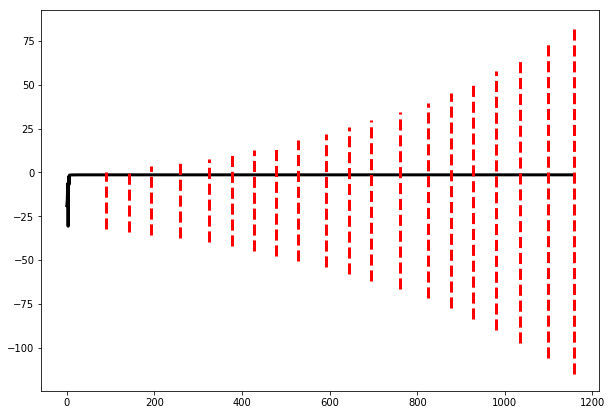

In [19]:
thetas_after_EM_step, J1s, J1_grads = optimiser.fit_using_analytic_q(X, theta0=theta0.reshape(-1), stop_threshold=1e-06)

# Learnt parameters compared with true parameters

In [20]:
print('Parameters learnt by the model.')
print('First element of matrix (scaling param) should equal {}'.format(-np.log(norm_const)))
model.theta.reshape(d+1, m+1)

Parameters learnt by the model.
First element of matrix (scaling param) should equal -4.794224095922242


array([[-8.49762344,  2.78962422,  2.80338641],
       [-3.31588912,  1.90353443,  2.1694497 ],
       [-2.01960286,  1.29945583,  0.90020962],
       [-1.45677951,  1.45115322,  0.47468773]])

In [21]:
print('True parameters.')
true_W

True parameters.


array([[0.35910033, 0.14837761, 0.30215639],
       [0.34452915, 0.02929255, 0.4992481 ],
       [0.03943207, 0.06609753, 0.11454542],
       [0.05250884, 0.0933997 , 0.4958152 ]])

# Visible marginal of model

In [45]:
all_visibles = model.get_all_binary_vectors(d)
model_visible_probs, model_norm_const = model.normalised_and_marginalised_over_z(all_visibles)

In [46]:
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(model_visible_probs)))

Sum over all visible probabilities should equal 1. We got: 1.0000000000000002


In [47]:
print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Data frequency is {}. Model frequency is {}'.format(all_visibles[i], 
                                                                    freq, model_visible_probs[i]))

-------------------------Visible probability checks--------------------------------------
[0 0 0]:  Data frequency is 0.0603. Model frequency is 0.061654002685034584
[0 0 1]:  Data frequency is 0.09238. Model frequency is 0.0921512549102745
[0 1 0]:  Data frequency is 0.06964. Model frequency is 0.06831185073936051
[0 1 1]:  Data frequency is 0.10589. Model frequency is 0.10683858205134672
[1 0 0]:  Data frequency is 0.11913. Model frequency is 0.11865015522265274
[1 0 1]:  Data frequency is 0.18829. Model frequency is 0.18785420103326064
[1 1 0]:  Data frequency is 0.14011. Model frequency is 0.1405453987308945
[1 1 1]:  Data frequency is 0.22426. Model frequency is 0.22399455462717602


In [48]:
print('normalisation constant is: {}.'.format(model_norm_const))

normalisation constant is: 1.0000738583037283


# Latent marginal of model

In [49]:
all_hiddens = true_data_dist.get_all_binary_vectors(m)
model_hidden_probs, model_norm_const = model.normalised_and_marginalised_over_u(all_hiddens)

In [50]:
print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(model_hidden_probs)))

Sum over all hidden probabilities should equal 1. We got: 1.0


In [51]:
print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Data frequency is {}. Model frequency is {}'.format(all_hiddens[i], 
                                                                    freq, model_hidden_probs[i]))

-------------------------Hidden probability checks--------------------------------------
[0 0]:  Data frequency is 0.1198637. Model frequency is 0.0002951611203407472
[0 1]:  Data frequency is 0.31535795. Model frequency is 0.008085070077869334
[1 0]:  Data frequency is 0.15377779. Model frequency is 0.012238070686202132
[1 1]:  Data frequency is 0.41100056. Model frequency is 0.9793816981155878


In [52]:
print('normalisation constant is: {}'.format(model_norm_const))

normalisation constant is: 1.0000738583037287


# Average log probabilities

$ \mathbb{E}_{x, z \sim P_{data}} \log(P_{model}(x, z)) \ \ \ \ \text{and} \ \ \ \ \mathbb{E}_{x, z \sim P_{model}} \log(P_{model}(x, z))$

In [53]:
model_X, model_Z = model.sample(n, num_iter=1000)
print('average log probability of P_model on true data: {} \n'
'average log probability of P_model on model data: {}'.format(
      np.mean(np.log(model(X, Z.reshape(1, n, -1)))), 
      np.mean(np.log(model(model_X, model_Z.reshape(1, n, -1))))))

average log probability of P_model on true data: -5.77958386198443 
average log probability of P_model on model data: -2.0948184821600178


$ \mathbb{E}_{x, z \sim P_{data}} \log(P_{data}(x, z)) \ \ \ \ \text{and} \ \ \ \ \mathbb{E}_{x, z \sim P_{model}} \log(P_{data}(x, z))$

In [54]:
print('average log probability of P_data on true data: {} \n'
'average log probability of P_data on model data: {}'.format(
      np.mean(np.log(true_data_dist(X, Z.reshape(1, n, -1))/norm_const)), 
      np.mean(np.log(true_data_dist(model_X, model_Z.reshape(1, n, -1))/norm_const))))

average log probability of P_data on true data: -3.2506030394327996 
average log probability of P_data on model data: -2.8986830659822322


$ \mathbb{E}_{x \sim P_{data}} \log(P_{model}(x)) \ \ \ \ \text{and} \ \ \ \ \mathbb{E}_{x \sim P_{model}} \log(P_{model}(x))$

In [68]:
model_probs_of_true_data, norm_const = model.normalised_and_marginalised_over_z(X)
model_probs_of_model_data, _ = model.normalised_and_marginalised_over_z(model_X)
print('average log probability of P_model x-marginal on true data: {} \n'
'average log probability of P_model x-marginal on model data: {}'.format(
      np.mean(np.log(model_probs_of_true_data)), 
      np.mean(np.log(model_probs_of_model_data))))

average log probability of P_model x-marginal on true data: -1.9912024109631352 
average log probability of P_model x-marginal on model data: -1.9917980172281433


$ \mathbb{E}_{x \sim P_{data}} \log(P_{data}(x)) \ \ \ \ \text{and} \ \ \ \ \mathbb{E}_{x \sim P_{model}} \log(P_{data}(x))$

In [69]:
true_dist_probs_of_true_data, norm_const = true_data_dist.normalised_and_marginalised_over_z(X)
true_dist_probs_of_model_data, _ = true_data_dist.normalised_and_marginalised_over_z(model_X)
print('average log probability of P_data x-marginal on true data: {} \n'
'average log probability of P_data x-marginal on model data: {}'.format(
      np.mean(np.log(true_dist_probs_of_true_data)), 
      np.mean(np.log(true_dist_probs_of_model_data))))

average log probability of P_data x-marginal on true data: -1.991195752019668 
average log probability of P_data x-marginal on model data: -1.9919055139361312
